# Visualizing The Application Data 
In this notebook, I visualize the data supplied in the application training dataset (which has the correct class information).  I start by loading some libraries to be used throughout the notebook.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt 

%matplotlib inline

plt.rc('font', size=16)
plt.rc('font', family='serif')

### Loading the Data
I am just going to load one of the seven different datasets, the application training dataset.  This includes on identification number per applicant called `SK_ID_CURR`.

In [2]:
path_to_data = '../data/raw'
samples = 5000

train_df = pd.read_csv('{}/application_train.csv'.format(path_to_data), nrows=samples)

In [3]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Overview
Let's start by getting an overview of the quantity and type of data that was supplied.  Above we can see that there are 122 columns provided in this application dataset.  In this section, the focus is more on the structure and content of the dataframe and less on the information contained in the data itself.

/usr/local/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,0,'Instances')

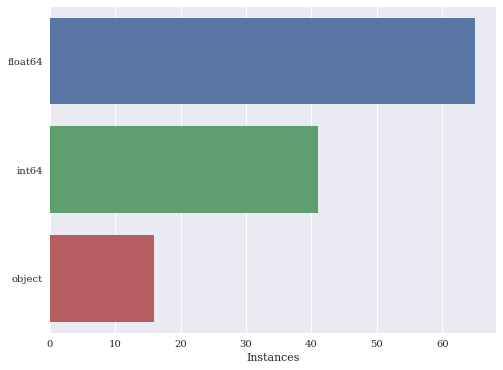

In [4]:
plt.figure( figsize=(8,6) )
ax = sb.barplot(y=train_df.get_dtype_counts().index, x=train_df.get_dtype_counts().values)
ax.set_xlabel('Instances')

Of those 122 variables, it looks like the majority are floats, but a significant fraction are categorical variables here labeled as objects.  Let's look into those categorical variables and see how many discreet values are used in each one.

Text(0.5,1,'Unique Values for Categorical Variables')

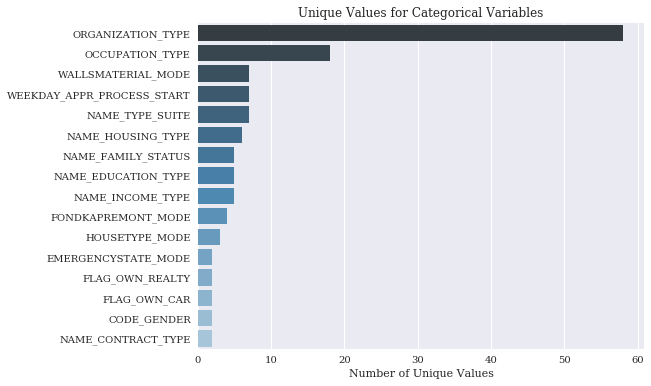

In [5]:
unique_categoricals = train_df.select_dtypes('object').nunique().sort_values(ascending=False)

plt.figure( figsize=(8,6) )
ax = sb.barplot(x=unique_categoricals.values, y=unique_categoricals.index,
          palette = 'Blues_d')
ax.set_xlabel('Number of Unique Values')
ax.set_title('Unique Values for Categorical Variables')

Knowing this information will help us later when we decide how to encode each categorical feature.  Let's now take a look at the fraction of the entries in each row which are missing in the training datatset.  Eventually, one should compare this to the testing dataset.

Text(0.5,0,'Missing Values (Percent)')

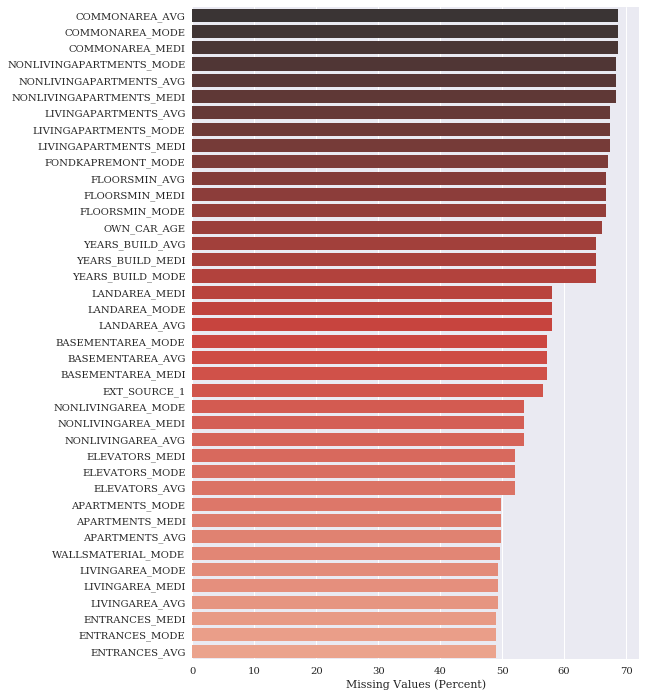

In [6]:
missing_series = train_df.isnull().sum().sort_values(ascending=False) 
missing_percent = missing_series / len(train_df) * 100

plt.figure( figsize=(8,12) )
ax = sb.barplot(y=missing_percent.index[:40], x=missing_percent.values[:40], 
           palette='Reds_d')
ax.set_xlabel('Missing Values (Percent)')

As we can see from the plot above, there are plent of columns with a serious amount of missing values (up to 70%).

### Digging Deeper
Let's now look into the information contained in the data itself.  We can start by checking the number of instances of each class we've been provided.  Then we can take a look at some features that might be useful by checking their correlation to the target.

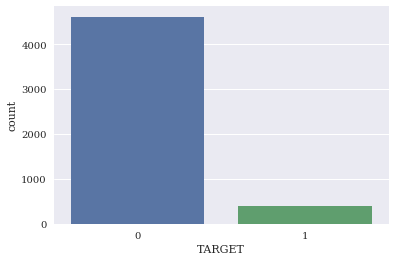

In [7]:
sb.countplot(train_df['TARGET'])

This problem is very unbalanced!  Most applicants don't have a risk of defaulting on their loan.  Let's look at correlations.

Text(0.5,0,'Magnitude of Correlation')

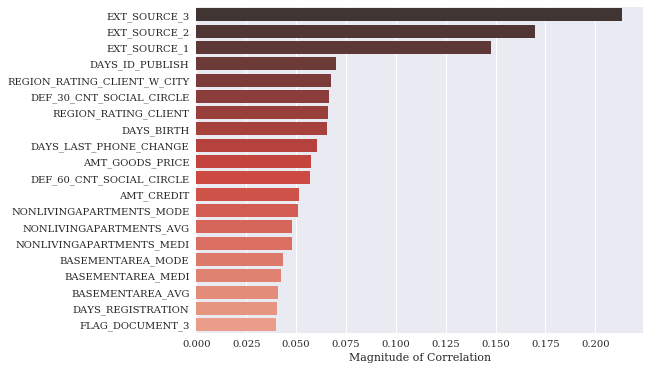

In [8]:
correlated_features = train_df.corr()['TARGET'].apply(np.abs).sort_values(ascending=False)
correlated_features.drop('TARGET', inplace=True)

plt.figure( figsize=(8,6) )
ax = sb.barplot(x=correlated_features.values[:20], 
                y=correlated_features.index[:20],
               palette='Reds_d')
ax.set_xlabel('Magnitude of Correlation')

It looks like external risk values provided are the strongest predictors of default risk.  Let's select the top 10 features and plot some more distributions for them.

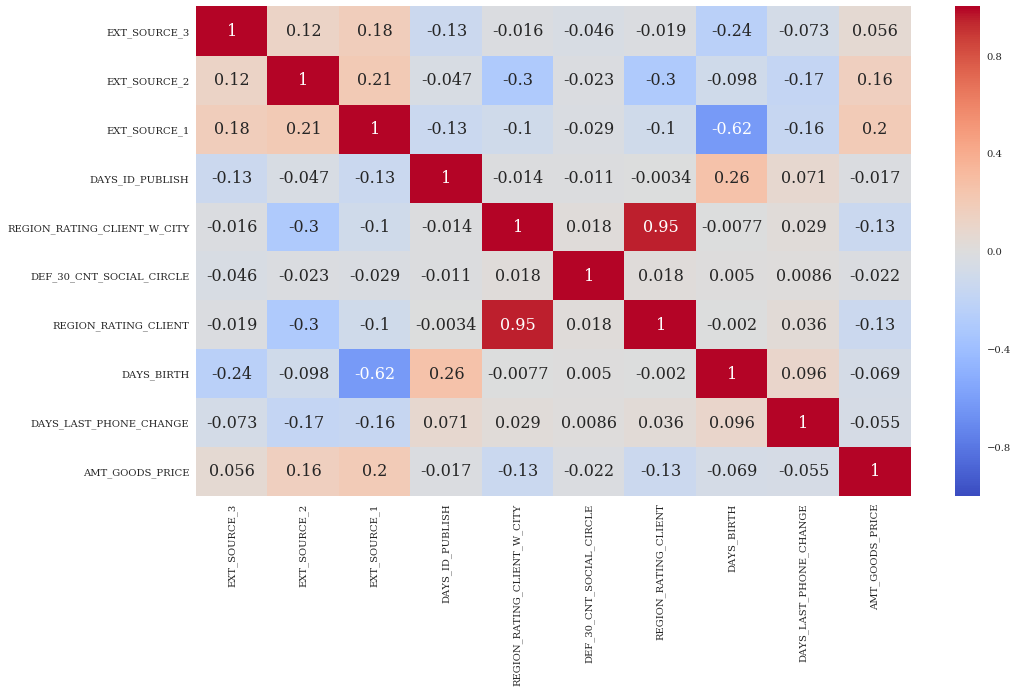

In [31]:
most_correlated_features = correlated_features.index[:10]
plt.figure( figsize=(16, 9) )
sb.heatmap(train_df[most_correlated_features].corr(), annot=True, cmap='coolwarm')

This correlation plot reveals that some of the varaibles which had large correlations with the target also have large correlations with each other, and most likely both of them won't be useful at the same time.  Let's look at the histogrammed distributions for these variables.  To do this we need to remove nan values, for now i'll just fill them with the means.

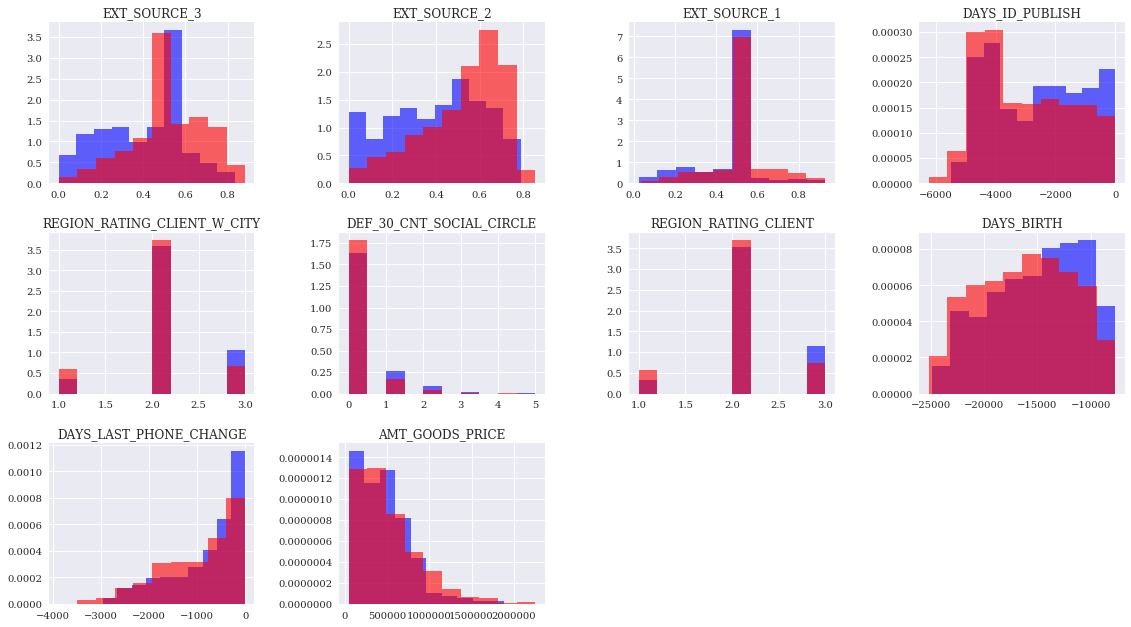

In [28]:
train_filled_df = train_df.fillna(train_df.mean(), axis=0)

n_cols = 3
n_features = len(most_correlated_features)
n_rows = np.ceil(n_features / n_cols) + 1

target_true_idx = np.where(train_filled_df['TARGET'].values == True)[0]
target_false_idx = np.where(train_filled_df['TARGET'].values == False)[0]

plt.figure( figsize=(4*n_rows, 3*n_cols) )

for index, feature in enumerate(most_correlated_features):
    plt.subplot(n_cols,n_rows,index+1)
    plt.hist(train_filled_df.iloc[target_true_idx][feature], density=True, alpha=0.6, color='blue')
    plt.hist(train_filled_df.iloc[target_false_idx][feature], density=True, alpha=0.6, color='red')
    plt.title(feature)
    
plt.tight_layout()